In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install textblob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 kB 4.4 MB/s eta 0:00:00


In [43]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from collections import Counter
import re
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score


# Data Preprocessing

In [ ]:
recipes_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IDMP/recipes.csv')
reviews_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IDMP/reviews.csv')

In [ ]:
def clean_ingredient_string(ingredient_string):
    ingredient_string = ingredient_string.strip().replace('c(', '').replace(')', '')
    ingredient_list = re.findall(r'\"(.*?)\"', ingredient_string)
    return ingredient_list

recipes_df['IngredientsList'] = recipes_df['RecipeIngredientParts'].apply(clean_ingredient_string)

In [ ]:
import pandas as pd

# Drop unnecessary columns from recipes.csv
recipes_df.drop(['AuthorId', 'AuthorName', 'DatePublished', 'Images', 'RecipeIngredientQuantities', 'CookTime', 'PrepTime', 'RecipeServings', 'RecipeInstructions', 'RecipeYield'], axis=1, inplace=True)

# Drop unnecessary columns from reviews.csv
reviews_df.drop(['AuthorId', 'AuthorName', 'DateSubmitted', 'DateModified'], axis=1, inplace=True)

# Join the two dataframes on 'RecipeId'
merged_df = pd.merge(reviews_df, recipes_df, on='RecipeId', how='inner')

# Impute missing values
merged_df.fillna(method='ffill', inplace=True)  # Forward fill missing values

# Display the entire integrated dataframe
pd.set_option('display.max_columns', None)  # Display all columns
print(merged_df)

         ReviewId  RecipeId  Rating  \
0               2       992       5   
1             250       992       5   
2          242612       992       5   
3          463486       992       4   
4          643932       992       5   
...           ...       ...     ...   
1401958   2090227    537537       5   
1401959   2090286    534306       1   
1401960   2090302    537541       3   
1401961   2090320    413571       5   
1401962   2090332    230339       5   

                                                    Review  \
0             better than any you can get at a restaurant!   
1        my family loved these.  fresher than any bough...   
2        Wow!  Awesome - Awesome - Awesome!  And I don'...   
3        This is a good recipe. I much prefer the oven ...   
4        GREAT recipe!  I used fat free cream cheese, p...   
...                                                    ...   
1401958  Great recipe! I made mine in a Bundt pan &amp;...   
1401959  The soy sauce ruined this 

In [ ]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1401982 entries, 0 to 1401981
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   ReviewId  1401982 non-null  int64 
 1   RecipeId  1401982 non-null  int64 
 2   Rating    1401982 non-null  int64 
 3   Review    1401768 non-null  object
dtypes: int64(3), object(1)
memory usage: 42.8+ MB


# EDA (Exploratory Data Analaysis)

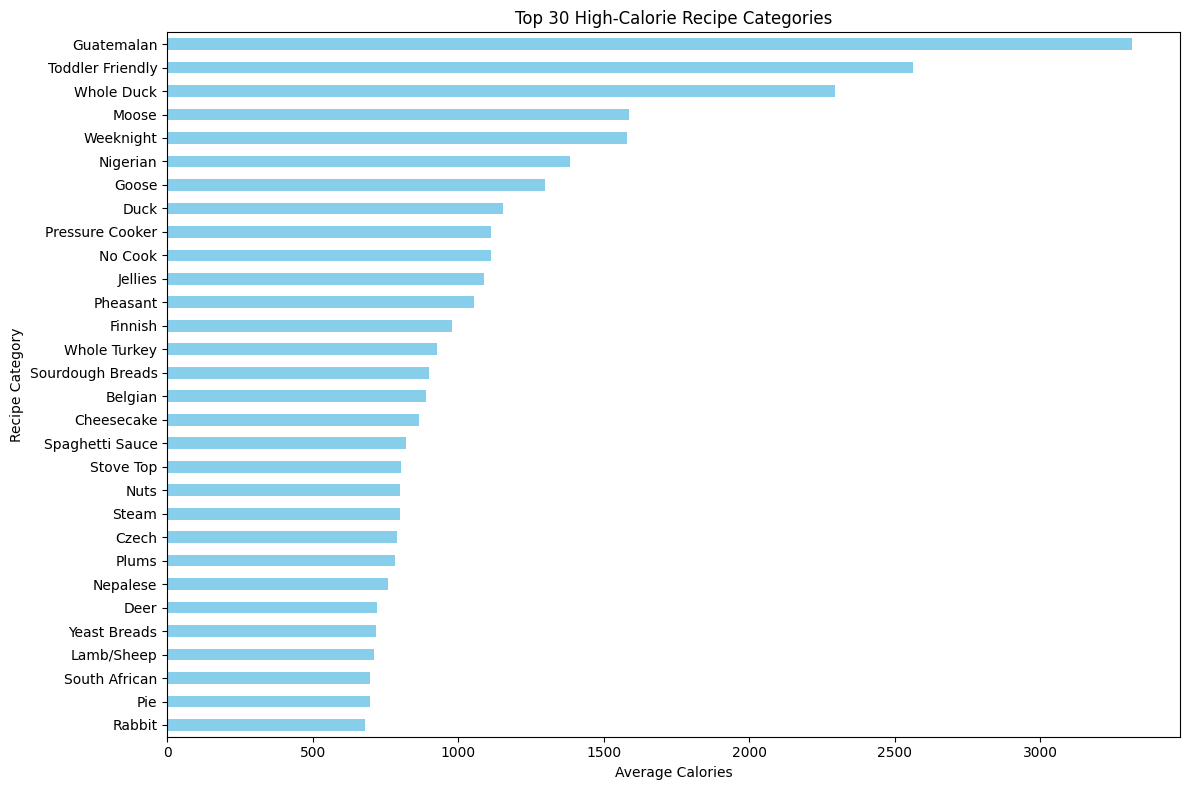

In [ ]:
category_calories = merged_df.groupby('RecipeCategory')['Calories'].mean()

top_categories = category_calories.nlargest(30)

plt.figure(figsize=(12, 8))
top_categories.sort_values().plot(kind='barh', color='skyblue')
plt.title('Top 30 High-Calorie Recipe Categories')
plt.xlabel('Average Calories')
plt.ylabel('Recipe Category')
plt.tight_layout()
plt.show()

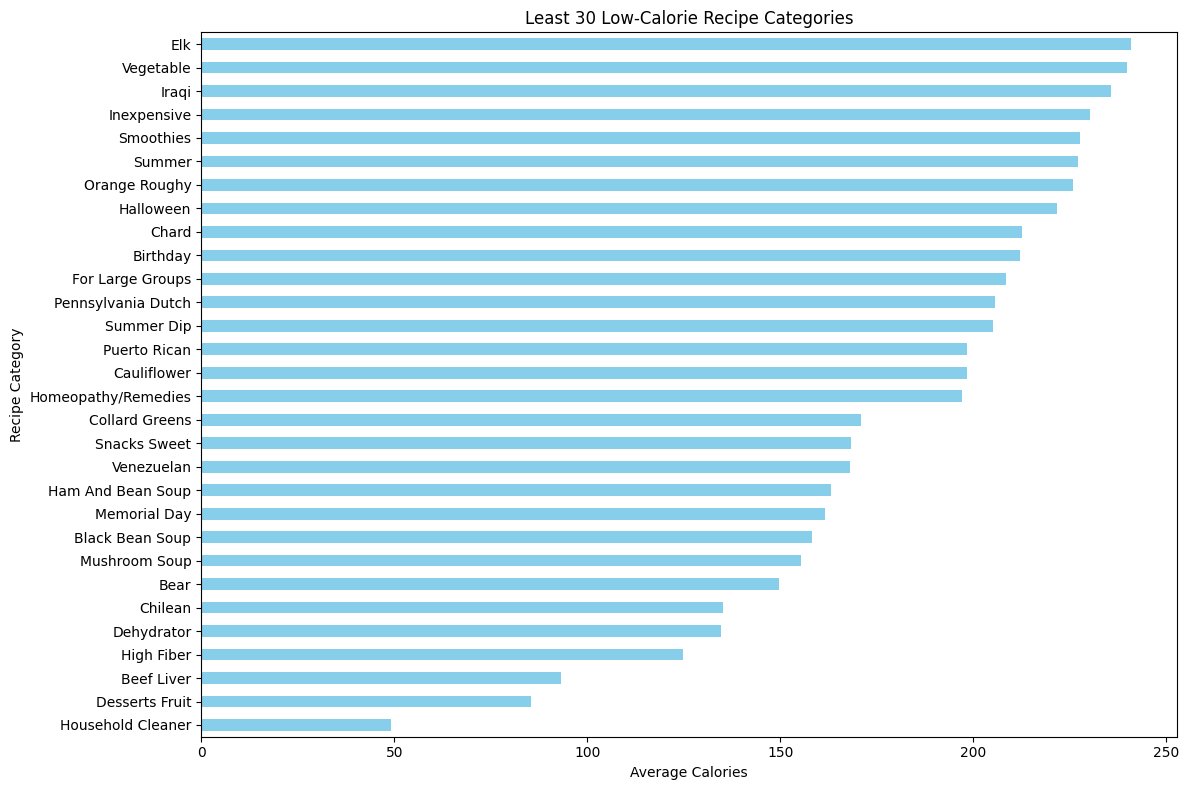

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Group the data by RecipeCategory and calculate the mean of Calories for each category
category_calories = merged_df.groupby('RecipeCategory')['Calories'].mean()


bottom_categories = category_calories.nsmallest(30)  # Bottom 30 categories with lowest average calories

# Plotting
plt.figure(figsize=(12, 8))
bottom_categories.plot(kind='barh', color='skyblue')  # Horizontal bar plot
plt.title('Least 30 Low-Calorie Recipe Categories')
plt.xlabel('Average Calories')
plt.ylabel('Recipe Category')
plt.tight_layout()
plt.show()

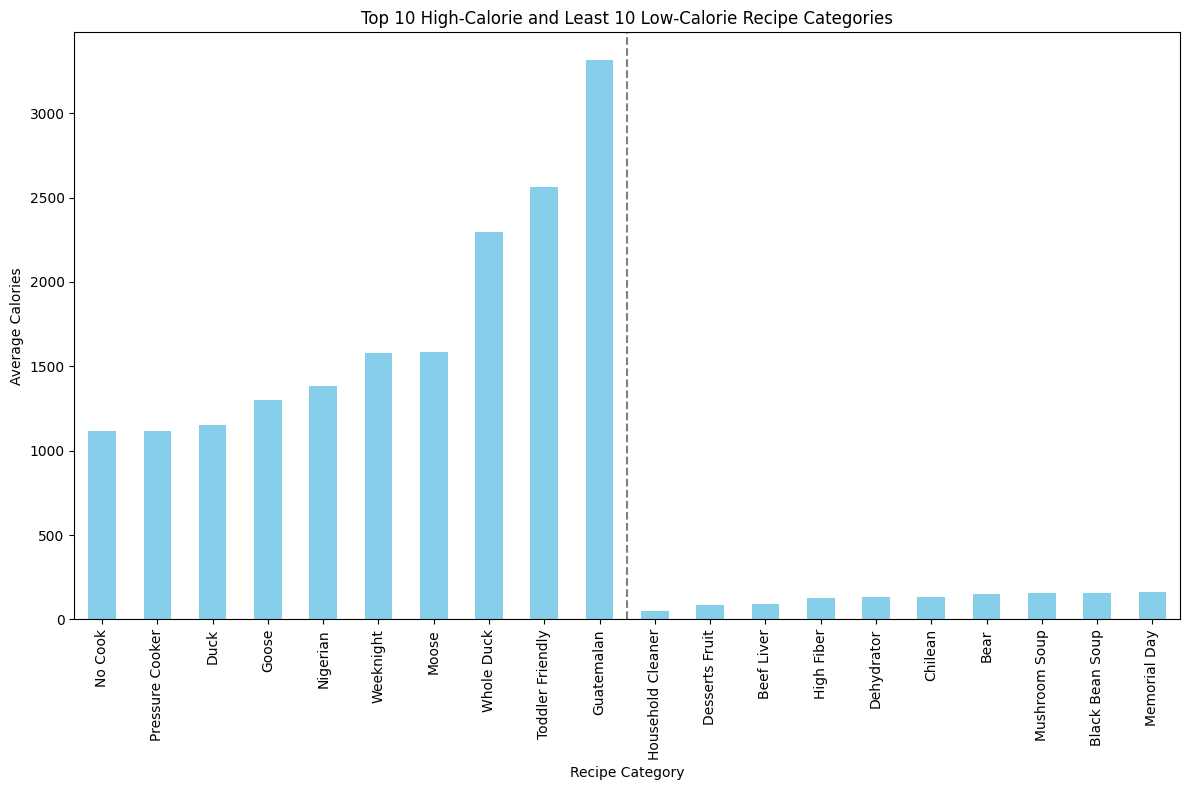

In [ ]:
category_calories = merged_df.groupby('RecipeCategory')['Calories'].mean()
sorted_categories = category_calories.sort_values()

top_categories = sorted_categories.tail(10)
bottom_categories = sorted_categories.head(10)

combined_categories = pd.concat([top_categories, bottom_categories])

line_position = len(top_categories)

plt.figure(figsize=(12, 8))
combined_categories.plot(kind='bar', color='skyblue')
plt.title('Top 10 High-Calorie and Least 10 Low-Calorie Recipe Categories')
plt.ylabel('Average Calories')
plt.xlabel('Recipe Category')
plt.axvline(x=line_position - 0.5, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

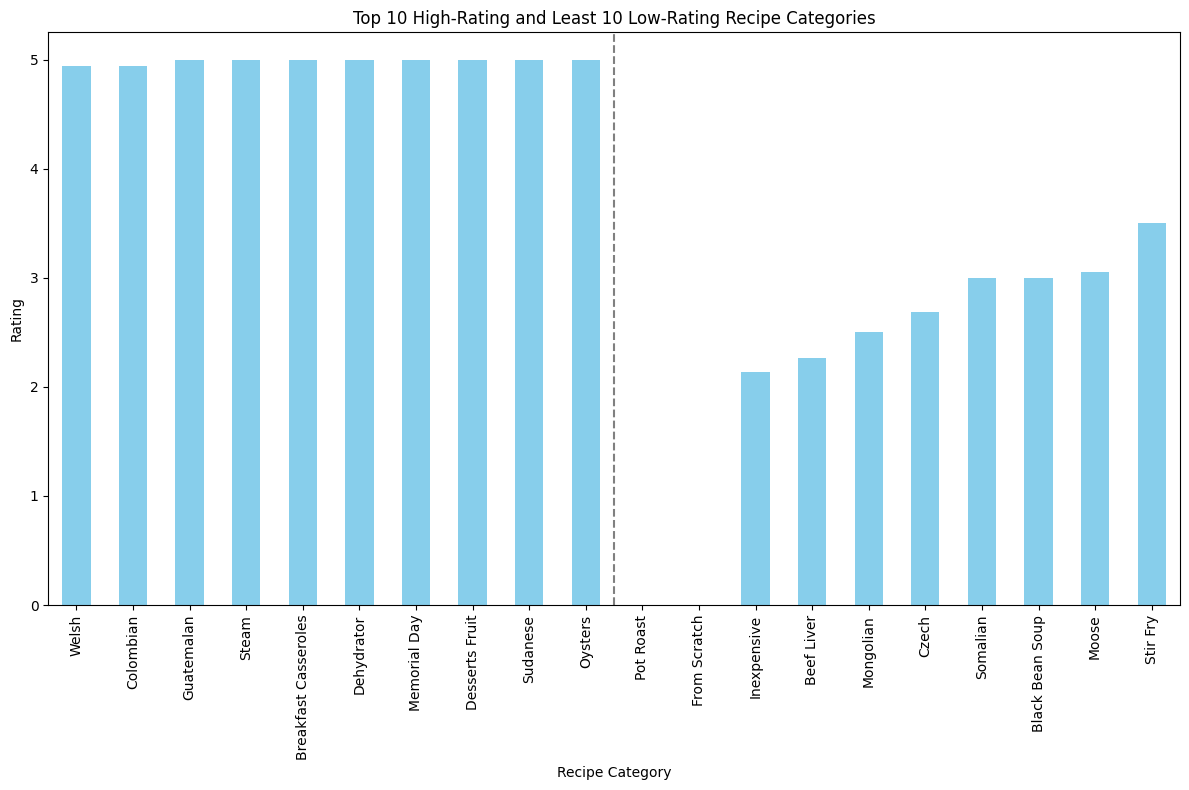

In [ ]:
category_calories = merged_df.groupby('RecipeCategory')['Rating'].mean()
sorted_categories = category_calories.sort_values()

top_categories = sorted_categories.tail(10)
bottom_categories = sorted_categories.head(10)

combined_categories = pd.concat([top_categories, bottom_categories])
line_position = len(top_categories)

plt.figure(figsize=(12, 8))
combined_categories.plot(kind='bar', color='skyblue')
plt.title('Top 10 High-Rating and Least 10 Low-Rating Recipe Categories')
plt.xlabel('Recipe Category')
plt.ylabel('Rating')
plt.axvline(x=line_position - 0.5, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

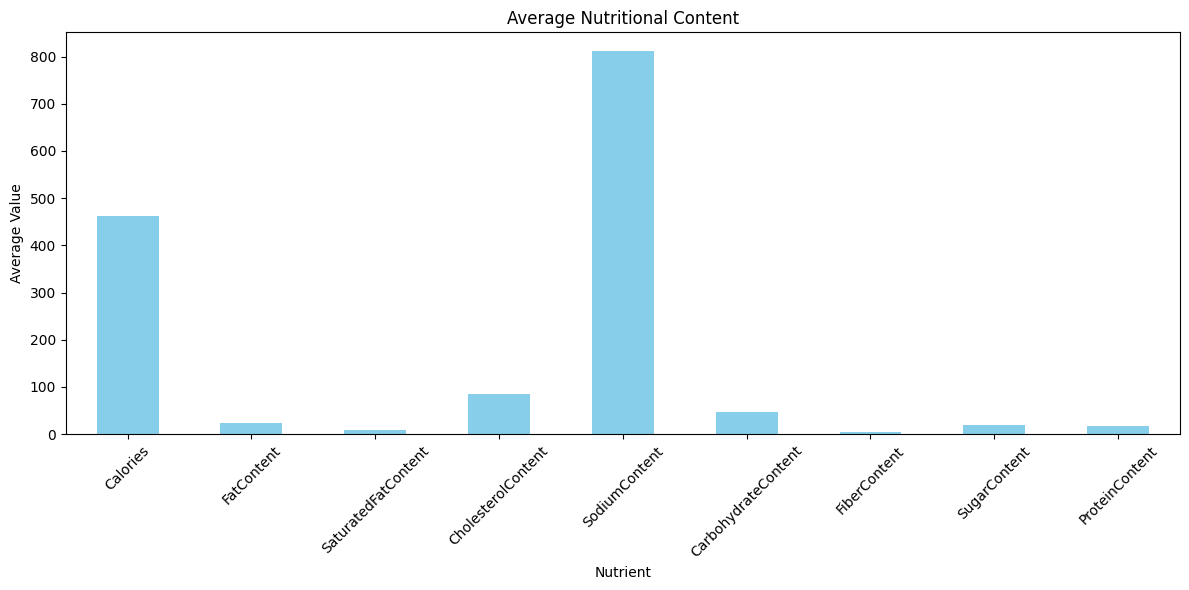

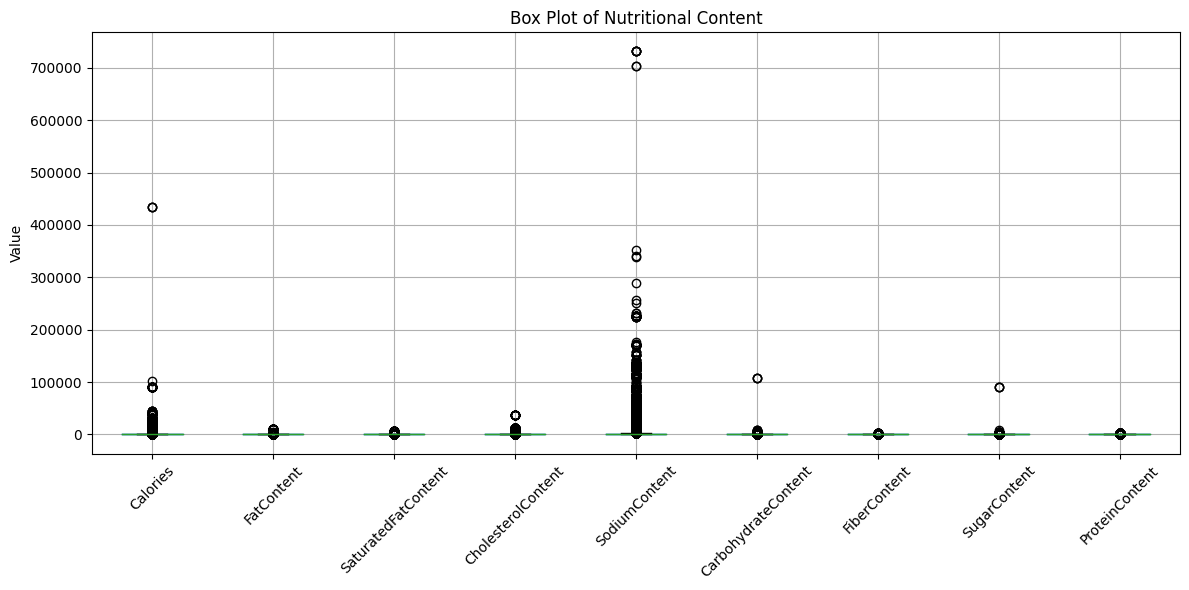

In [ ]:
columns_of_interest = ['Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent',
                       'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent',
                       'ProteinContent']

averages = merged_df[columns_of_interest].mean()

plt.figure(figsize=(12, 6))
averages.plot(kind='bar', color='skyblue')
plt.title('Average Nutritional Content')
plt.xlabel('Nutrient')
plt.ylabel('Average Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
merged_df[columns_of_interest].boxplot()
plt.title('Box Plot of Nutritional Content')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


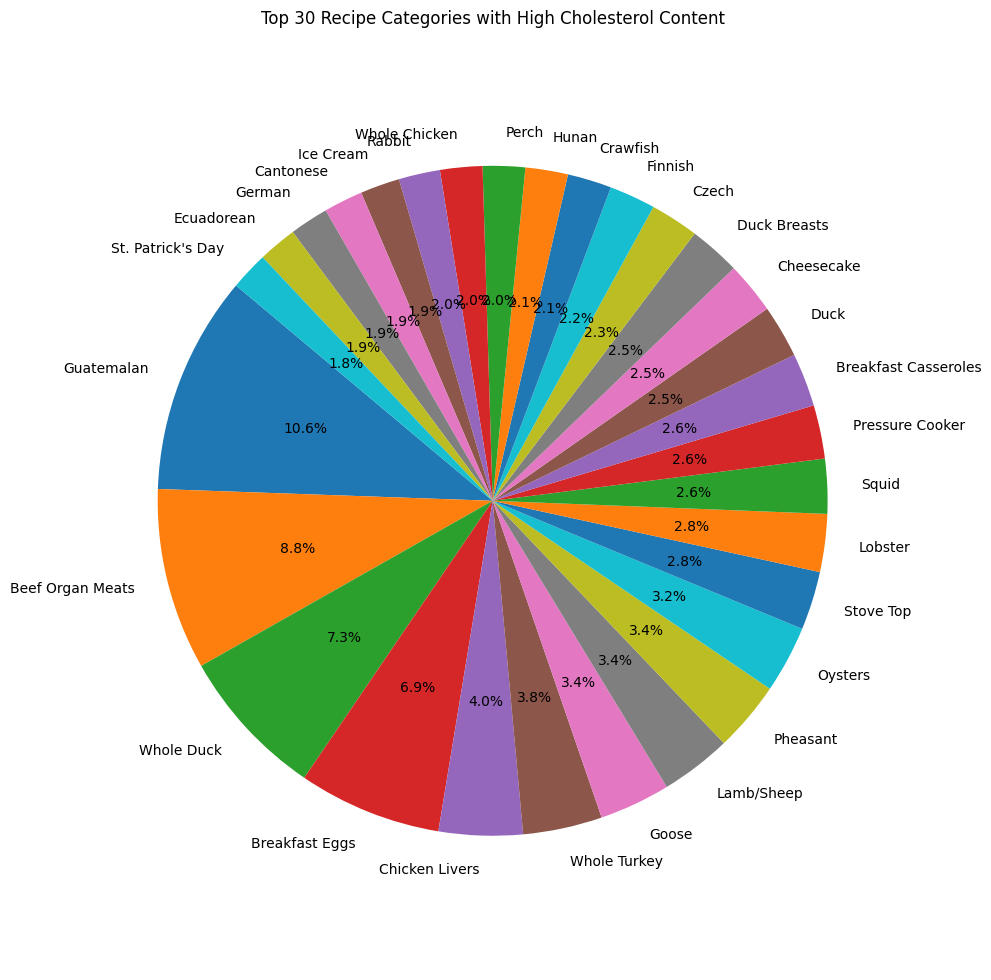

In [ ]:
top_fiber_categories = merged_df.groupby('RecipeCategory')['CholesterolContent'].mean().nlargest(30)

plt.figure(figsize=(10, 10))
plt.pie(top_fiber_categories, labels=top_fiber_categories.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 30 Recipe Categories with High Cholesterol Content')
plt.axis('equal')
plt.tight_layout()
plt.show()

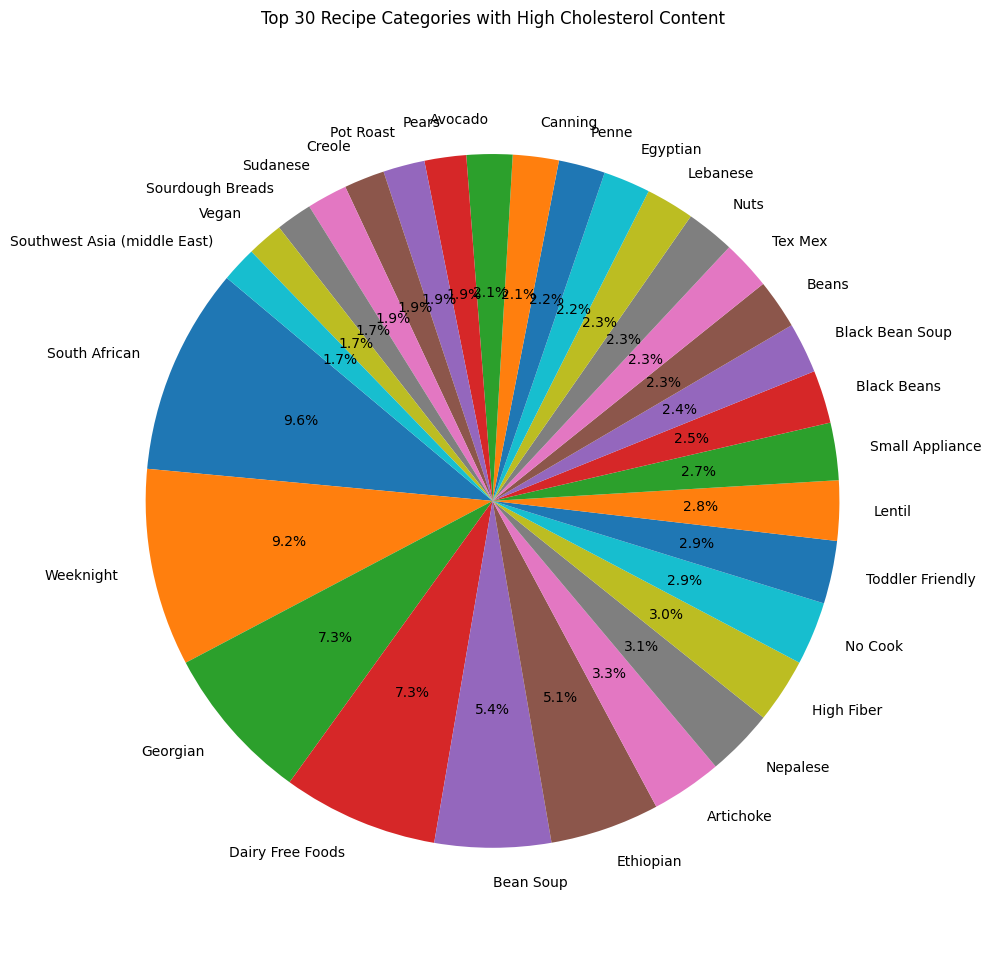

In [47]:
top_fiber_categories = merged_df.groupby('RecipeCategory')['FiberContent'].mean().nlargest(30)

plt.figure(figsize=(10, 10))
plt.pie(top_fiber_categories, labels=top_fiber_categories.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 30 Recipe Categories with High Cholesterol Content')
plt.axis('equal')
plt.tight_layout()
plt.show()

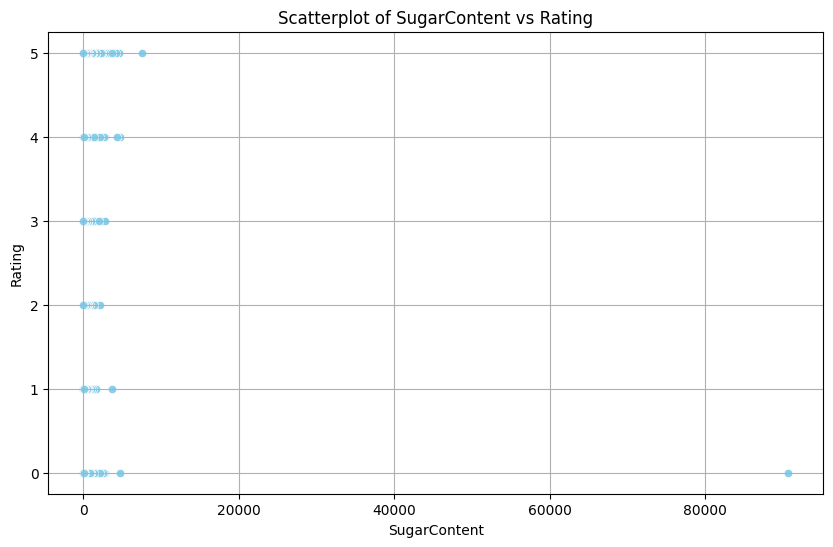

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='SugarContent', y='Rating', data=merged_df, color='skyblue')

plt.title('Scatterplot of SugarContent vs Rating')
plt.xlabel('SugarContent')
plt.ylabel('Rating')
plt.grid(True)

plt.show()

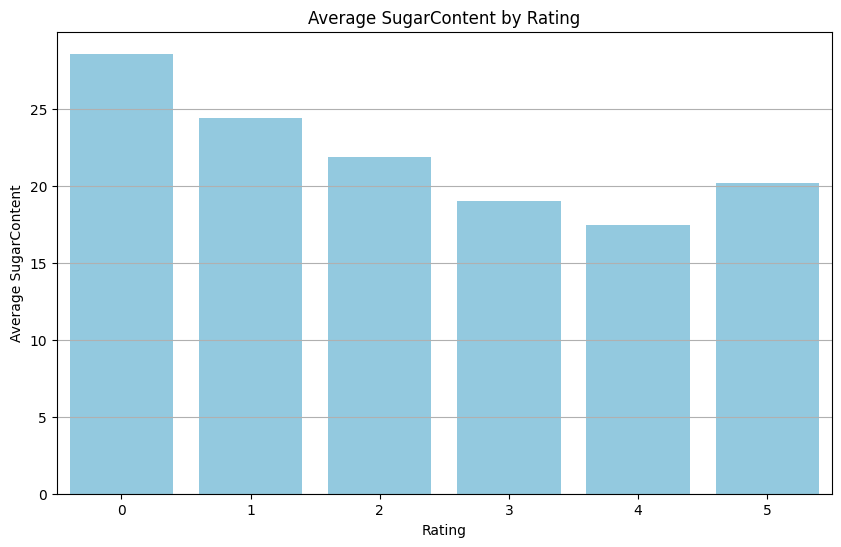

In [ ]:
rating_sugar_mean = merged_df.groupby('Rating')['SugarContent'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Rating', y='SugarContent', data=rating_sugar_mean, color='skyblue')

plt.title('Average SugarContent by Rating')
plt.xlabel('Rating')
plt.ylabel('Average SugarContent')
plt.grid(axis='y')

plt.show()


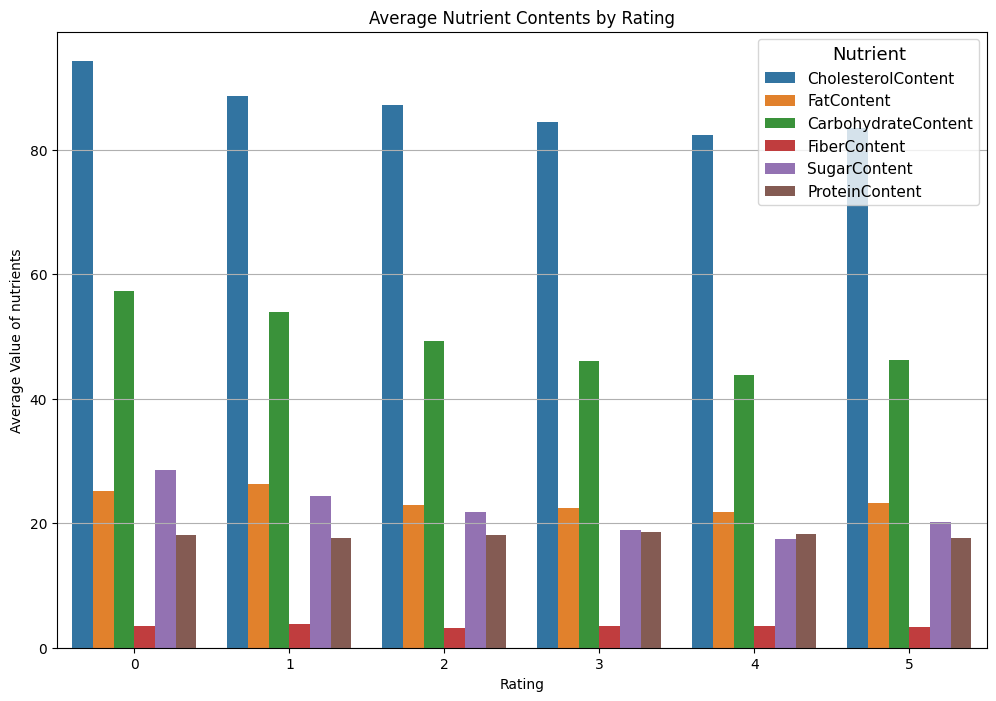

In [ ]:
rating_nutrient_mean = merged_df.groupby('Rating').agg({
    'CholesterolContent': 'mean',
    'FatContent': 'mean',
    'CarbohydrateContent': 'mean',
    'FiberContent': 'mean',
    'SugarContent': 'mean',
    'ProteinContent': 'mean'
}).reset_index()


melted_data = rating_nutrient_mean.melt(id_vars='Rating', var_name='Nutrient', value_name='Average')


plt.figure(figsize=(12, 8))
sns.barplot(x='Rating', y='Average', hue='Nutrient', data=melted_data)

plt.title('Average Nutrient Contents by Rating')
plt.xlabel('Rating')
plt.ylabel('Average Value of nutrients')
plt.legend(title='Nutrient', title_fontsize='13', fontsize='11')
plt.grid(axis='y')

plt.show()

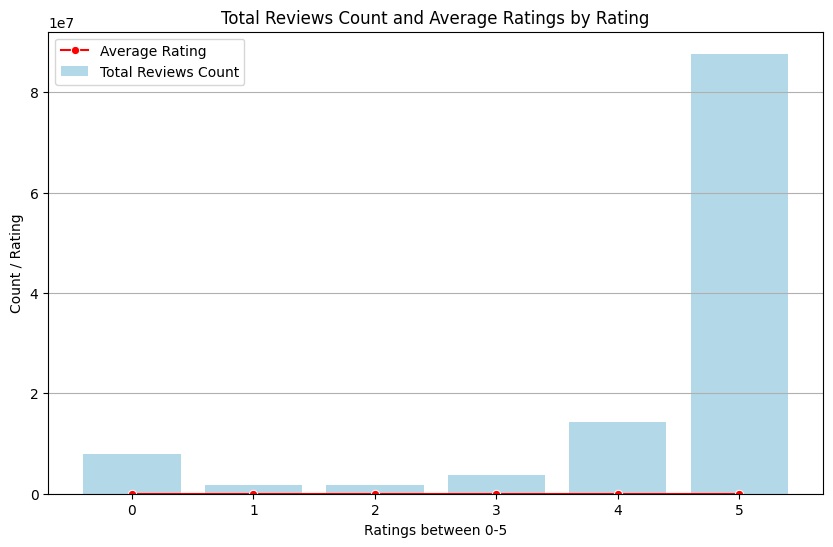

In [ ]:
rating_reviews_avg = merged_df.groupby('Rating').agg({'ReviewCount': 'sum', 'AggregatedRating': 'mean'}).reset_index()


plt.figure(figsize=(10, 6))
sns.barplot(x='Rating', y='ReviewCount', data=rating_reviews_avg, color='skyblue', alpha=0.7, label='Total Reviews Count')
sns.lineplot(x='Rating', y='AggregatedRating', data=rating_reviews_avg, color='red', marker='o', label='Average Rating')

plt.title('Total Reviews Count and Average Ratings by Rating')
plt.xlabel('Ratings between 0-5')
plt.ylabel('Count / Rating')
plt.legend()
plt.grid(axis='y')

plt.show()

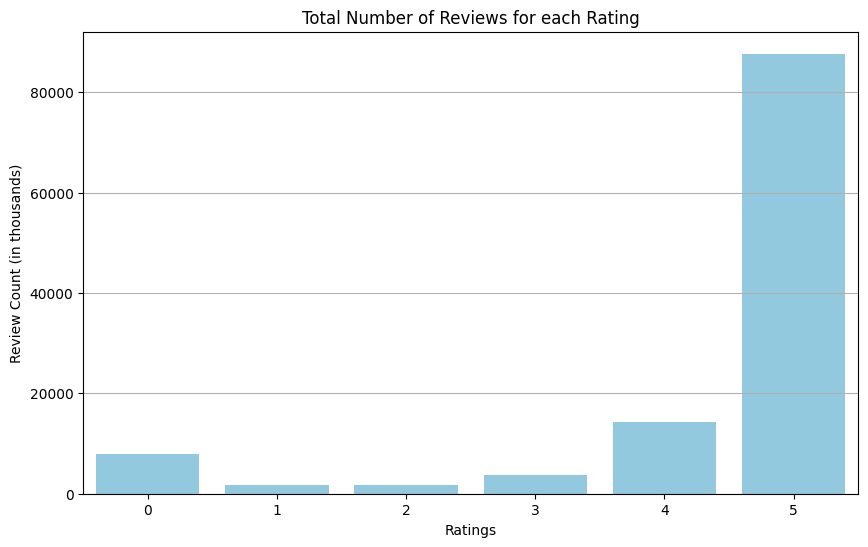

In [ ]:
rating_review_count = merged_df.groupby('Rating')['ReviewCount'].sum().reset_index()


rating_review_count['ReviewCount'] /= 1000


plt.figure(figsize=(10, 6))
sns.barplot(x='Rating', y='ReviewCount', data=rating_review_count, color='skyblue')

plt.title('Total Number of Reviews for each Rating')
plt.xlabel('Ratings')
plt.ylabel('Review Count (in thousands)')
plt.grid(axis='y')

plt.show()

# Sentiment Analysis

In [20]:
nltk.download('vader_lexicon')
def clean_txt(txt):
    txt = re.sub(r'@[A-Za-z0-9]+', '', txt)
    txt = re.sub(r'#', '', txt)
    txt = re.sub(r'RT[\s]+', '', txt)
    txt = re.sub(r'https?:\/\/\S+', '', txt)
    return txt

reviews_df['Review'] = reviews_df['Review'].fillna('').astype(str)
reviews_df['CleanedReview'] = reviews_df['Review'].apply(clean_txt)

sia = SentimentIntensityAnalyzer()

def get_sentiments(text):
    blob = TextBlob(text)
    vader = sia.polarity_scores(text)
    return blob.polarity, blob.subjectivity, vader['compound']

reviews_df = reviews_df.drop_duplicates(subset=['Review'], keep='first')
reviews_df[['Polarity', 'Subjectivity', 'Compound']] = reviews_df['CleanedReview'].apply(lambda x: pd.Series(get_sentiments(x)))


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [21]:
recipe_sentiments = reviews_df.groupby('RecipeId').agg({'Polarity': 'mean', 'Subjectivity': 'mean', 'Compound': 'mean'}).reset_index()
recipes_df = recipes_df.merge(recipe_sentiments, on='RecipeId', how='left')

In [24]:
recipes_df.head()

,RecipeId,Name,TotalTime,Description,RecipeCategory,Keywords,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,IngredientsList,Polarity,Subjectivity,Compound
0,38,Low-Fat Berry Blue Frozen Dessert,PT24H45M,Make and share this Low-Fat Berry Blue Frozen ...,Frozen Desserts,"c(""Dessert"", ""Low Protein"", ""Low Cholesterol"",...","c(""blueberries"", ""granulated sugar"", ""vanilla ...",4.5,4.0,170.9,2.5,1.3,8.0,29.8,37.1,3.6,30.2,3.2,"[blueberries, granulated sugar, vanilla yogurt...",0.397917,0.638333,0.709500
1,39,Biryani,PT4H25M,Make and share this Biryani recipe from Food.com.,Chicken Breast,"c(""Chicken Thigh & Leg"", ""Chicken"", ""Poultry"",...","c(""saffron"", ""milk"", ""hot green chili peppers""...",3.0,1.0,1110.7,58.8,16.6,372.8,368.4,84.4,9.0,20.4,63.4,"[saffron, milk, hot green chili peppers, onion...",0.050000,0.300000,0.877800
2,40,Best Lemonade,PT35M,This is from one of my first Good House Keepi...,Beverages,"c(""Low Protein"", ""Low Cholesterol"", ""Healthy"",...","c(""sugar"", ""lemons, rind of"", ""lemon, zest of""...",4.5,10.0,311.1,0.2,0.0,0.0,1.8,81.5,0.4,77.2,0.3,"[sugar, lemons, rind of, lemon, zest of, fresh...",0.397198,0.668843,0.754033
3,41,Carina's Tofu-Vegetable Kebabs,PT24H20M,This dish is best prepared a day in advance to...,Soy/Tofu,"c(""Beans"", ""Vegetable"", ""Low Cholesterol"", ""We...","c(""extra firm tofu"", ""eggplant"", ""zucchini"", ""...",4.5,2.0,536.1,24.0,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,"[extra firm tofu, eggplant, zucchini, mushroom...",0.516250,0.718750,0.928200
4,42,Cabbage Soup,PT50M,Make and share this Cabbage Soup recipe from F...,Vegetable,"c(""Low Protein"", ""Vegan"", ""Low Cholesterol"", ""...","c(""plain tomato juice"", ""cabbage"", ""onion"", ""c...",4.5,11.0,103.6,0.4,0.1,0.0,959.3,25.1,4.8,17.7,4.3,"[plain tomato juice, cabbage, onion, carrots, ...",0.300929,0.594522,0.668922


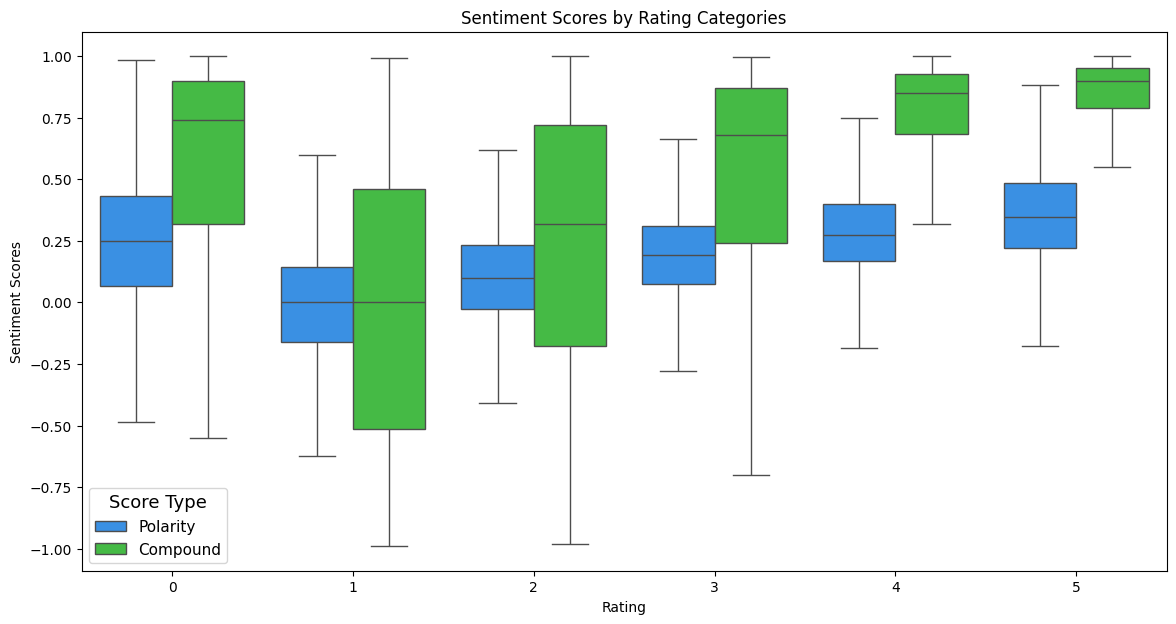

In [25]:
melted_reviews = pd.melt(reviews_df, id_vars=['Rating'], value_vars=['Polarity', 'Compound'],
                         var_name='ScoreType', value_name='Score')

plt.figure(figsize=(14, 7))


sns.boxplot(x='Rating', y='Score', hue='ScoreType', data=melted_reviews,
            palette={'Polarity': 'dodgerblue', 'Compound': 'limegreen'}, showfliers=False)

plt.title('Sentiment Scores by Rating Categories')
plt.xlabel('Rating')
plt.ylabel('Sentiment Scores')
plt.legend(title='Score Type', title_fontsize='13', fontsize='11')

plt.show()

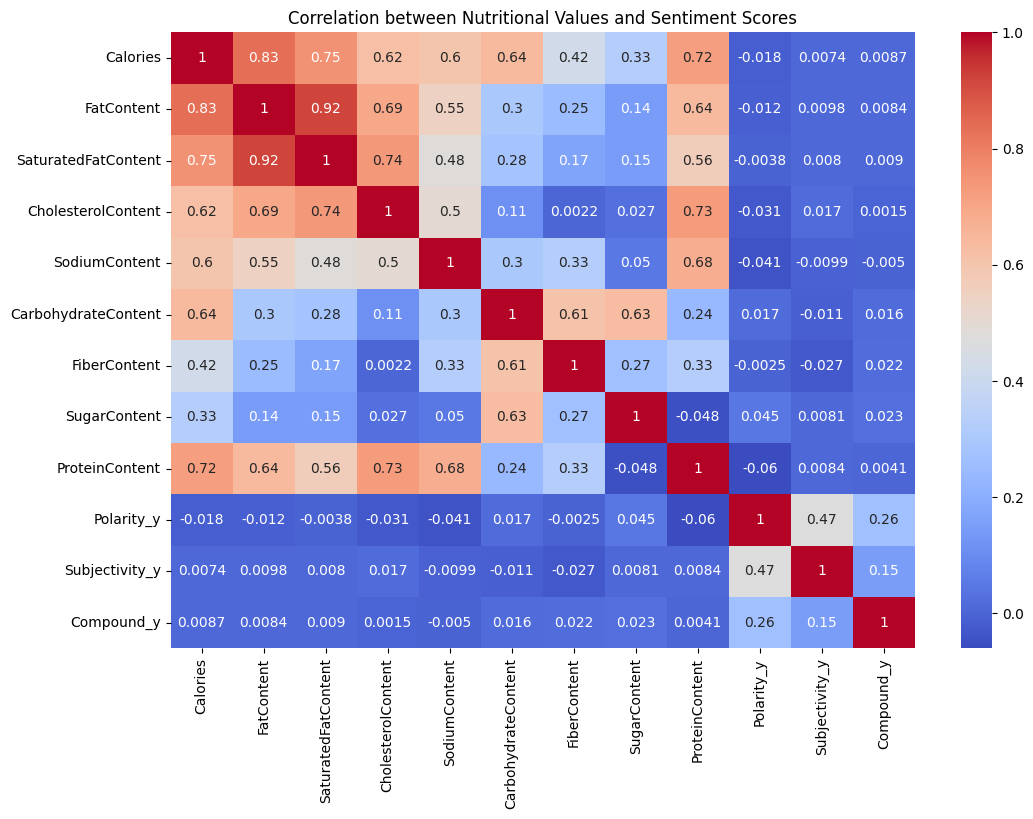

In [26]:
recipes_with_reviews = recipes_df.merge(reviews_df, on='RecipeId')
recipes_with_reviews.head()
nutritional_columns = ['Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent']
sentiment_columns = ['Polarity_y', 'Subjectivity_y', 'Compound_y']
nutritional_data = recipes_with_reviews[nutritional_columns + sentiment_columns].dropna()

spearman_corr = nutritional_data.corr(method='spearman')
plt.figure(figsize=(12, 8))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm')

plt.title('Correlation between Nutritional Values and Sentiment Scores')
plt.show()

In [27]:
def categorize_sentiment_compound(score):
    if score > 0.1:
        return 'Positive'
    elif score < -0.29:
        return 'Negative'
    else:
        return 'Neutral'

def categorize_sentiment_polarity(score):
    if score > 0.1:
        return 'Positive'
    elif score < -0.15:
        return 'Negative'
    else:
        return 'Neutral'

recipes_df['CompoundCategory'] = recipes_df['Compound'].apply(categorize_sentiment_compound)
recipes_df['PolarityCategory'] = recipes_df['Polarity'].apply(categorize_sentiment_polarity)
reviews_df['CompoundCategory'] = reviews_df['Compound'].apply(categorize_sentiment_compound)
reviews_df['PolarityCategory'] = reviews_df['Polarity'].apply(categorize_sentiment_polarity)


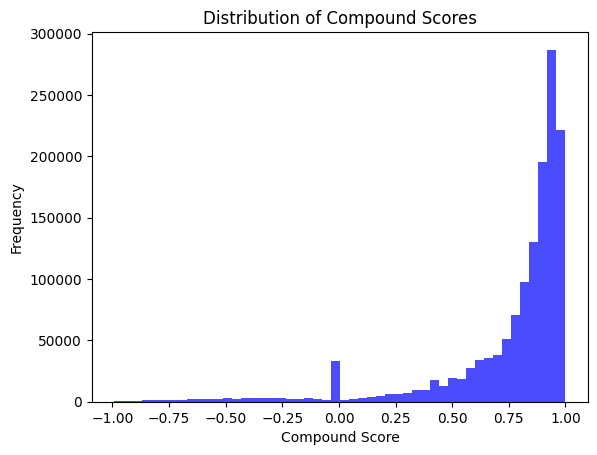

In [28]:
plt.hist(reviews_df['Compound'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Compound Scores')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')
plt.show()

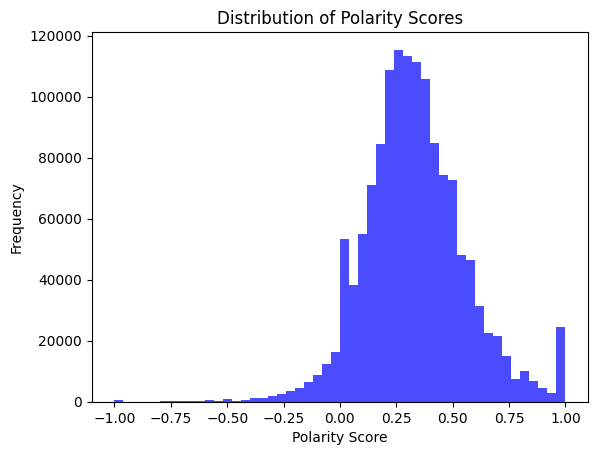

In [29]:
plt.hist(reviews_df['Polarity'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Polarity Scores')
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.show()

In [30]:
def aggregate_ingredients(df):
    all_ingredients = Counter()
    for ingredients in df['IngredientsList']:
        all_ingredients.update(ingredients)
    return all_ingredients

all_ingredients_counter = aggregate_ingredients(recipes_df)

total_recipes = recipes_df['RecipeId'].nunique()

threshold_common = total_recipes * 0.1  # 10%
threshold_widely_used = total_recipes * 0.05  # 5%

ingredients_to_exclude = {
    ingredient
    for ingredient, count in all_ingredients_counter.items()
    if count > threshold_widely_used
}

In [31]:
def aggregate_ingredients_exclude_threshold(df, exclude_set):
    ingredient_counter = Counter()
    for ingredients in df['IngredientsList']:
        for ingredient in ingredients:
            if ingredient not in exclude_set:
                ingredient_counter[ingredient] += 1
    return ingredient_counter

all_ingredients_counter = aggregate_ingredients(recipes_df)

total_recipes = recipes_df['RecipeId'].nunique()

threshold_common = total_recipes * 0.1  # 10%
threshold_widely_used = total_recipes * 0.05  # 5%

ingredients_to_exclude = {
    ingredient
    for ingredient, count in all_ingredients_counter.items()
    if count > threshold_widely_used
}

<ipython-input-33-5c702516af90>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Ingredient', y='Frequency', data=data, palette=colors)


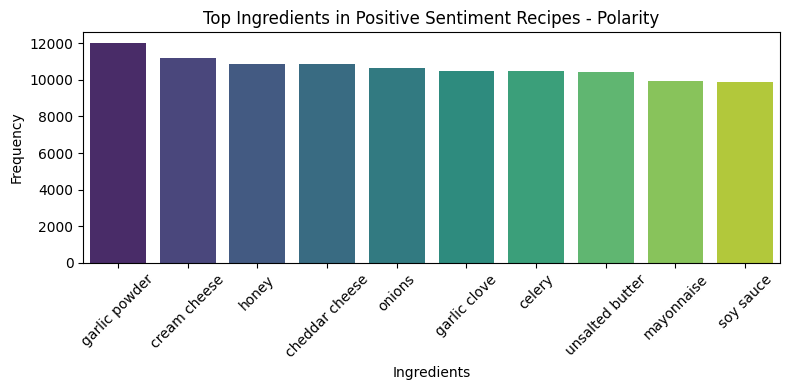

<ipython-input-33-5c702516af90>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Ingredient', y='Frequency', data=data, palette=colors)


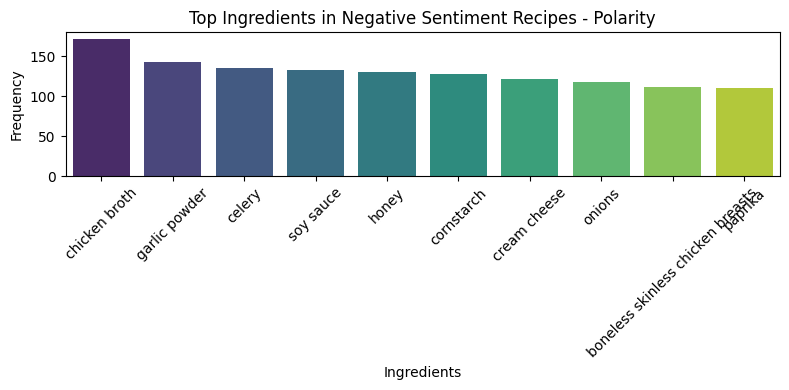

In [33]:
positive_ingredients = aggregate_ingredients_exclude_threshold(
    recipes_df[recipes_df['Polarity'] > 0.1],
    ingredients_to_exclude
)


negative_ingredients = aggregate_ingredients_exclude_threshold(
    recipes_df[recipes_df['Polarity'] < -0.1],
    ingredients_to_exclude
)


def plot_top_ingredients_seaborn(ingredient_counter, title, num_top=10):
    top_ingredients = ingredient_counter.most_common(num_top)
    ingredients, counts = zip(*top_ingredients)

    data = pd.DataFrame({'Ingredient': ingredients, 'Frequency': counts})

    colors = sns.color_palette('viridis', n_colors=num_top)

    plt.figure(figsize=(8, 4))
    sns.barplot(x='Ingredient', y='Frequency', data=data, palette=colors)

    plt.title(title)
    plt.xlabel('Ingredients')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

plot_top_ingredients_seaborn(positive_ingredients, 'Top Ingredients in Positive Sentiment Recipes - Polarity')
plot_top_ingredients_seaborn(negative_ingredients, 'Top Ingredients in Negative Sentiment Recipes - Polarity')


<ipython-input-33-5c702516af90>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Ingredient', y='Frequency', data=data, palette=colors)


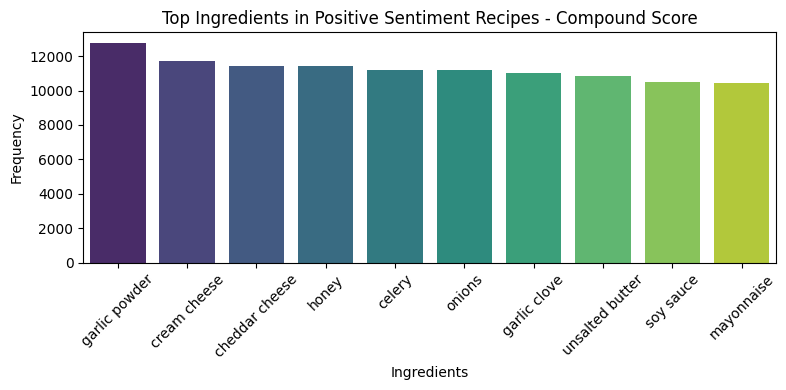

<ipython-input-33-5c702516af90>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Ingredient', y='Frequency', data=data, palette=colors)


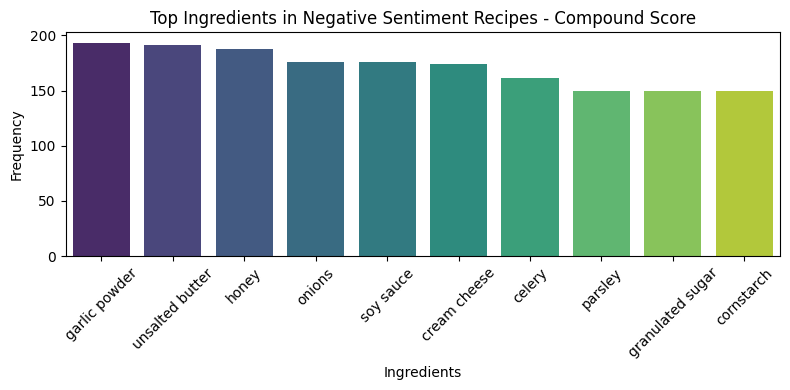

In [34]:
positive_ingredients = aggregate_ingredients_exclude_threshold(
    recipes_df[recipes_df['Compound'] > 0.1],
    ingredients_to_exclude
)

negative_ingredients = aggregate_ingredients_exclude_threshold(
    recipes_df[recipes_df['Compound'] < -0.1],
    ingredients_to_exclude
)

plot_top_ingredients_seaborn(positive_ingredients, 'Top Ingredients in Positive Sentiment Recipes - Compound Score')
plot_top_ingredients_seaborn(negative_ingredients, 'Top Ingredients in Negative Sentiment Recipes - Compound Score')


In [35]:
sorted_df = reviews_df.sort_values(by=['Polarity', 'Rating'], ascending=[False, True])
sorted_df.tail(10)[['Review', 'Polarity', 'Rating']]

,Review,Polarity,Rating
1299394,Definetily the worst cookie I ever had,-1.0,5
1313805,This is terrible I can't stop eating it.,-1.0,5
1321650,"I add thinly sliced onion to mine, yum!!!!!",-1.0,5
1362873,It's just yummy! It is a pudding one ounce box...,-1.0,5
1375754,Here is a switch use a brownie mix as the base!!!,-1.0,5
1378445,Charlie was/is a Chicken Salad genius! I made ...,-1.0,5
1386260,"For a shortbread like crust, cook the base for...",-1.0,5
1392323,Yum! Ate this for lunch for a week and hated t...,-1.0,5
1399158,If you are looking to step away from the canne...,-1.0,5
1400780,This recipe has been our Christmas morning tra...,-1.0,5


In [36]:
sorted_df_c = reviews_df.sort_values(by=['Compound', 'Rating'], ascending=[False, True])
last_ten_indices = sorted_df.tail(10).index
sorted_df_c.loc[last_ten_indices][['Review', 'Compound', 'Rating']]

,Review,Compound,Rating
1299394,Definetily the worst cookie I ever had,-0.6249,5
1313805,This is terrible I can't stop eating it.,-0.2987,5
1321650,"I add thinly sliced onion to mine, yum!!!!!",0.0000,5
1362873,It's just yummy! It is a pudding one ounce box...,0.6103,5
1375754,Here is a switch use a brownie mix as the base!!!,0.0000,5
1378445,Charlie was/is a Chicken Salad genius! I made ...,0.3129,5
1386260,"For a shortbread like crust, cook the base for...",0.4199,5
1392323,Yum! Ate this for lunch for a week and hated t...,-0.6988,5
1399158,If you are looking to step away from the canne...,0.6239,5
1400780,This recipe has been our Christmas morning tra...,0.0000,5


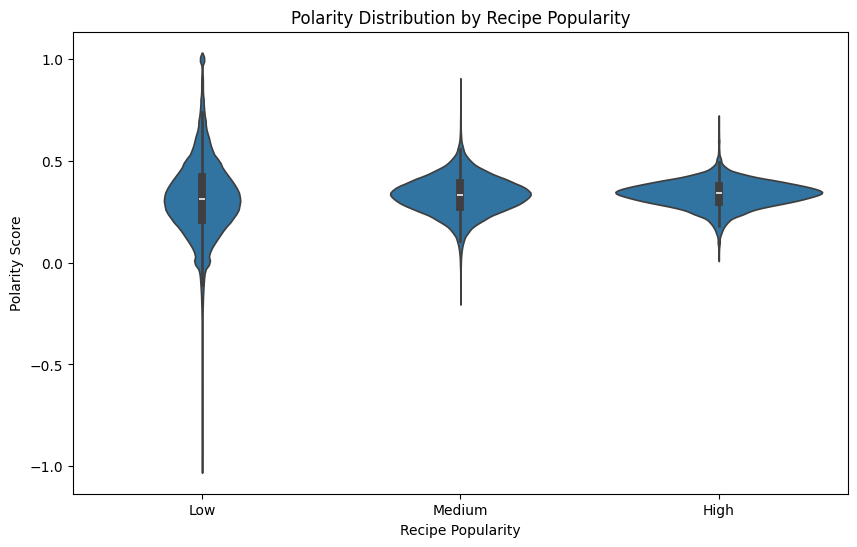

In [37]:
review_counts = reviews_df['RecipeId'].value_counts().reset_index()
review_counts.columns = ['RecipeId', 'ReviewCount']

recipes_with_counts = recipes_df.merge(review_counts, on='RecipeId', how='left')

recipe_popularity = reviews_df.groupby('RecipeId').size().reset_index(name='ReviewCount')


recipes_sentiment_popularity = recipes_with_counts.merge(recipe_popularity, on='RecipeId', how='left')

bins = [0, 5, 20, float('inf')]
bin_labels = ['Low', 'Medium', 'High']
recipes_sentiment_popularity['PopularityCategory'] = pd.cut(recipes_sentiment_popularity['ReviewCount'], bins=bins, labels=bin_labels)

plt.figure(figsize=(10, 6))
sns.violinplot(x='PopularityCategory', y='Polarity', data=recipes_sentiment_popularity)
plt.title('Polarity Distribution by Recipe Popularity')
plt.xlabel('Recipe Popularity')
plt.ylabel('Polarity Score')
plt.show()


In [39]:
annotations_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IDMP/annotations.csv')
reviews_df = reviews_df.merge(annotations_df, on='Review', how='left')

In [40]:
def standardize_sentiment(value):
    value = str(value).strip().lower()
    if 'positive' in value:
        return 'Positive'
    elif 'negative' in value:
        return 'Negative'
    elif 'neutral' in value or 'mixed' in value:
        return 'Neutral'
reviews_df['standardized_sentiment'] = reviews_df['annotated_sentiment'].apply(standardize_sentiment)


In [41]:
filtered_reviews = reviews_df.dropna(subset=['standardized_sentiment'])
filtered_reviews['PolarityCategory'] = filtered_reviews['PolarityCategory'].str.capitalize()
filtered_reviews['CompoundCategory'] = filtered_reviews['CompoundCategory'].str.capitalize()

<ipython-input-41-253e7f1ee88f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_reviews['PolarityCategory'] = filtered_reviews['PolarityCategory'].str.capitalize()
<ipython-input-41-253e7f1ee88f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_reviews['CompoundCategory'] = filtered_reviews['CompoundCategory'].str.capitalize()


In [44]:
textblob_report = classification_report(
    filtered_reviews['standardized_sentiment'],
    filtered_reviews['PolarityCategory'],
    output_dict=True
)

vader_report = classification_report(
    filtered_reviews['standardized_sentiment'],
    filtered_reviews['CompoundCategory'],
    output_dict=True
)


textblob_df = pd.DataFrame(textblob_report).transpose()
vader_df = pd.DataFrame(vader_report).transpose()

neat_table = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-score', 'Accuracy'],
    'TextBlob': [
        textblob_df.loc['macro avg', 'precision'],
        textblob_df.loc['macro avg', 'recall'],
        textblob_df.loc['macro avg', 'f1-score'],
        textblob_df.loc['accuracy', 'f1-score']
    ],
    'VADER': [
        vader_df.loc['macro avg', 'precision'],
        vader_df.loc['macro avg', 'recall'],
        vader_df.loc['macro avg', 'f1-score'],
        vader_df.loc['accuracy', 'f1-score']
    ]
})

neat_table[['TextBlob', 'VADER']] = neat_table[['TextBlob', 'VADER']].applymap(lambda x: f"{x:.2%}")

print(neat_table)

      Metric TextBlob   VADER
0  Precision   54.40%  51.85%
1     Recall   50.30%  52.68%
2   F1-score   51.36%  52.23%
3   Accuracy   65.63%  66.16%


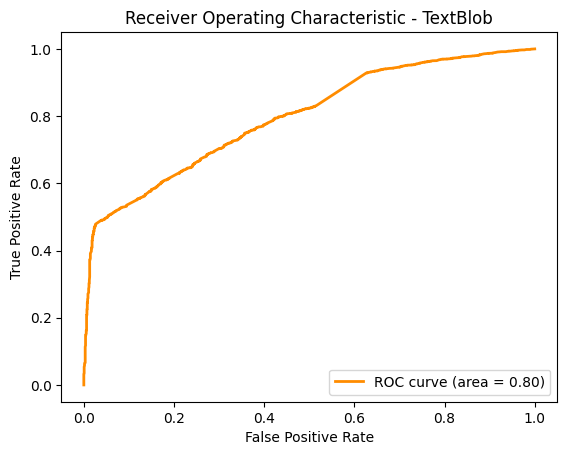

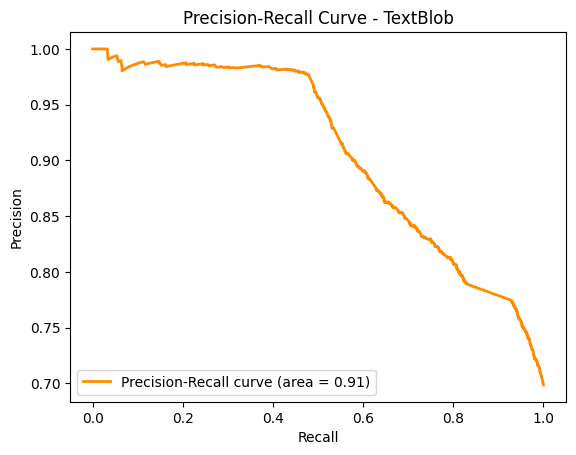

In [45]:
binary_true_labels = (filtered_reviews['standardized_sentiment'] == 'Positive').astype(int)
binary_predicted_scores = filtered_reviews['Polarity'].apply(lambda x: (x + 1) / 2)  # Normalizing TextBlob scores

fpr, tpr, thresholds = roc_curve(binary_true_labels, binary_predicted_scores)
roc_auc = auc(fpr, tpr)

precision, recall, thresholds = precision_recall_curve(binary_true_labels, binary_predicted_scores)
average_precision = average_precision_score(binary_true_labels, binary_predicted_scores)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - TextBlob')
plt.legend(loc="lower right")
plt.show()

plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - TextBlob')
plt.legend(loc="lower left")
plt.show()

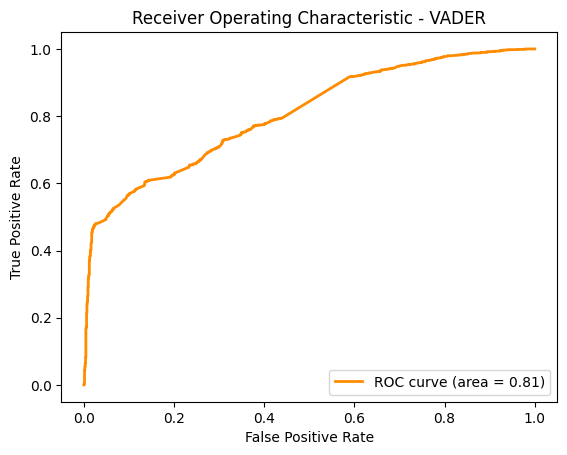

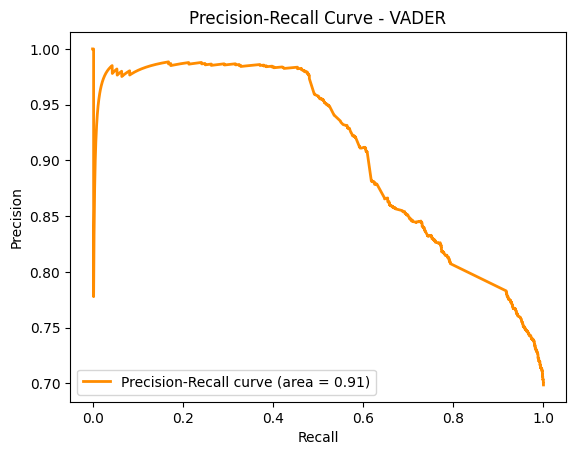

In [46]:
binary_true_labels_vader = (filtered_reviews['standardized_sentiment'] == 'Positive').astype(int)
binary_predicted_scores_vader = filtered_reviews['Compound'].apply(lambda x: (x + 1) / 2)


fpr_vader, tpr_vader, thresholds_vader = roc_curve(binary_true_labels_vader, binary_predicted_scores_vader)
roc_auc_vader = auc(fpr_vader, tpr_vader)

precision_vader, recall_vader, thresholds_vader = precision_recall_curve(binary_true_labels_vader, binary_predicted_scores_vader)
average_precision_vader = average_precision_score(binary_true_labels_vader, binary_predicted_scores_vader)


plt.figure()
plt.plot(fpr_vader, tpr_vader, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_vader)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - VADER')
plt.legend(loc="lower right")
plt.show()


plt.figure()
plt.plot(recall_vader, precision_vader, color='darkorange', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision_vader)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - VADER')
plt.legend(loc="lower left")
plt.show()